In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install conllu

import numpy as np 
import pandas as pd 
import conllu
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b300dtxt/glove.6B.300d.txt
/kaggle/input/pos-tag/en_atis-ud-train.conllu
/kaggle/input/pos-tag/en_atis-ud-test.conllu
/kaggle/input/pos-tag/en_atis-ud-dev.conllu
/kaggle/input/googlewordtovec/GoogleNews-vectors-negative300.bin
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Loading dataset
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math


class TreeBankDataset(Dataset):
    def __init__(self, filepath):
        with open(filepath, "r", encoding="utf-8") as f:
            data = f.read()
        parsed_data = conllu.parse(data)
        self.data = []
        for sentence in parsed_data:
            tagged_sentence_word = []
            tagged_sentence_tag = []
            for token in sentence:
                word = token["form"]
                pos = token["upos"]
                tagged_sentence_word.append(word)
                tagged_sentence_tag.append(pos)
            self.data.append((tagged_sentence_word,tagged_sentence_tag))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [4]:
dataset_train = TreeBankDataset("/kaggle/input/pos-tag/en_atis-ud-train.conllu")
dataset_test = TreeBankDataset("/kaggle/input/pos-tag/en_atis-ud-test.conllu")
dataset_dev = TreeBankDataset("/kaggle/input/pos-tag/en_atis-ud-dev.conllu")

In [5]:
# training sentences and their corresponding word-tags
training_data = dataset_train

# create a dictionary that maps words to indices
word2idx = {}
tag2idx = {}
idx2tag = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

for sent, tags in training_data:
    for tag in tags:
        if tag not in tag2idx:
            tag2idx[tag] = len(tag2idx)
            idx2tag[len(idx2tag)] = tag

word2idx["UNK"] = len(word2idx)
tag2idx['UNK'] = len(tag2idx)
idx2tag[len(idx2tag)] = 'UNK'

In [6]:
print(training_data[0])

(['what', 'is', 'the', 'cost', 'of', 'a', 'round', 'trip', 'flight', 'from', 'pittsburgh', 'to', 'atlanta', 'beginning', 'on', 'april', 'twenty', 'fifth', 'and', 'returning', 'on', 'may', 'sixth'], ['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADP', 'NOUN', 'NUM', 'ADJ', 'CCONJ', 'VERB', 'ADP', 'NOUN', 'ADJ'])


In [7]:
# print out the created dictionary
print(word2idx)
print(tag2idx)

{'what': 0, 'is': 1, 'the': 2, 'cost': 3, 'of': 4, 'a': 5, 'round': 6, 'trip': 7, 'flight': 8, 'from': 9, 'pittsburgh': 10, 'to': 11, 'atlanta': 12, 'beginning': 13, 'on': 14, 'april': 15, 'twenty': 16, 'fifth': 17, 'and': 18, 'returning': 19, 'may': 20, 'sixth': 21, 'now': 22, 'i': 23, 'need': 24, 'leaving': 25, 'fort': 26, 'worth': 27, 'arriving': 28, 'in': 29, 'denver': 30, 'no': 31, 'later': 32, 'than': 33, '2': 34, 'pm': 35, 'next': 36, 'monday': 37, 'fly': 38, 'kansas': 39, 'city': 40, 'chicago': 41, 'wednesday': 42, 'following': 43, 'day': 44, 'meaning': 45, 'meal': 46, 'code': 47, 's': 48, 'show': 49, 'me': 50, 'all': 51, 'flights': 52, 'which': 53, 'serve': 54, 'for': 55, 'after': 56, 'tomorrow': 57, 'us': 58, 'air': 59, 'list': 60, 'nonstop': 61, 'early': 62, 'tuesday': 63, 'morning': 64, 'dallas': 65, 'st.': 66, 'petersburg': 67, 'toronto': 68, 'that': 69, 'arrive': 70, 'listing': 71, 'new': 72, 'york': 73, 'montreal': 74, 'canada': 75, 'departing': 76, 'thursday': 77, 'amer

In [8]:
import numpy as np

def texts_to_sequences(text, word_index):
    sequence = []
    for token in text:
        if token in word_index.keys():
            sequence.append(word_index[token])
        else:
            sequence.append(word_index['UNK'])
    sequence = np.array(sequence)
    return torch.from_numpy(sequence)

In [9]:
# Checking texts_to_sequences
example_input = texts_to_sequences("i am going via flight".lower().split(), word2idx)

print(example_input)

tensor([ 23, 141, 131, 339,   8])


In [10]:
from gensim.models import KeyedVectors
path = '/kaggle/input/googlewordtovec/GoogleNews-vectors-negative300.bin'

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [11]:
EMBEDDING_SIZE = 300
VOCABULARY_SIZE = len(word2idx)

embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

for word, index in word2idx.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
            pass

In [12]:
embedding_weights = torch.from_numpy(embedding_weights)

In [13]:
print(embedding_weights)

tensor([[ 0.1396, -0.0062,  0.2148,  ...,  0.0571,  0.0996, -0.2344],
        [ 0.0070, -0.0732,  0.1719,  ...,  0.0112,  0.1641,  0.1069],
        [ 0.0801,  0.1050,  0.0498,  ...,  0.0037,  0.0476, -0.0688],
        ...,
        [-0.0820, -0.0098,  0.0142,  ..., -0.2021,  0.0713,  0.1621],
        [-0.3809,  0.0444, -0.0811,  ..., -0.1963, -0.1396,  0.0311],
        [-0.0947, -0.5117,  0.0581,  ...,  0.3906, -0.0034,  0.2812]],
       dtype=torch.float64)


In [14]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings, dropout = 0.3):
        ''' Initialize the layers of this model.'''
        super(BiLSTMTagger, self).__init__()
        
        self.hidden_dim = hidden_dim

        # embedding layer that turns words into a vector of a specified size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.copy_(pretrained_embeddings)
        # the LSTM takes embedded word vectors (of a specified size) as inputs 
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        
        # initialize the hidden state (see code below)
        self.hidden = self.init_hidden()

        
    def init_hidden(self):
        ''' At the start of training, we need to initialize a hidden state;
           there will be none because the hidden state is formed based on perviously seen data.
           So, this function defines a hidden state with all zeroes and of a specified size.'''
        # The axes dimensions are (n_layers, batch_size, hidden_dim)
        return (torch.zeros(2, 1, self.hidden_dim),
                torch.zeros(2, 1, self.hidden_dim))

    def forward(self, sentence):
        ''' Define the feedforward behavior of the model.'''
        # create embedded word vectors for each word in a sentence
        embeds = self.word_embeddings(sentence)
        
        # get the output and hidden state by passing the lstm over our word embeddings
        # the lstm takes in our embeddings and hiddent state
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        
        lstm_out = self.dropout(lstm_out)
        
        # get the scores for the most likely tag for a word
        tag_outputs = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_outputs, dim=1)
        
        return tag_scores

In [15]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

# instantiate our model
model = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), len(tag2idx), embedding_weights)

# define our loss and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [16]:
test_sentence = "flights are available".lower().split()

# see what the scores are before training
# element [i,j] of the output is the *score* for tag j for word i.
# to check the initial accuracy of our model, we don't need to train, so we use model.eval()
inputs = texts_to_sequences(test_sentence, word2idx)
inputs = inputs
tag_scores = model(inputs)
print(tag_scores)

# tag_scores outputs a vector of tag scores for each word in an inpit sentence
# to get the most likely tag index, we grab the index with the maximum score!
# recall that these numbers correspond to tag2idx = {"DET": 0, "NN": 1, "V": 2}
_, predicted_tags = torch.max(tag_scores, 1)
print('\n')
print('Predicted tags: \n',predicted_tags)

tensor([[-2.5616, -2.6327, -2.5706, -2.6047, -2.7254, -2.6175, -2.6383, -2.6775,
         -2.5494, -2.6522, -2.6178, -2.7332, -2.7011, -2.6874],
        [-2.6340, -2.6442, -2.6015, -2.5951, -2.7211, -2.5912, -2.5876, -2.6494,
         -2.5862, -2.6443, -2.6555, -2.6880, -2.6860, -2.6748],
        [-2.5882, -2.6044, -2.6561, -2.5935, -2.6937, -2.6038, -2.6569, -2.5973,
         -2.5871, -2.6532, -2.6425, -2.7020, -2.6973, -2.6832]],
       grad_fn=<LogSoftmaxBackward0>)


Predicted tags: 
 tensor([8, 8, 8])


In [17]:
import random
from sklearn.metrics import classification_report

n_epochs = 2
batch_size = 16
accuracy = {}
accuracy_dev = {} 
accuracy_test = {} 

for epoch in range(n_epochs):
    y_true = []
    y_pred = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    target_names = ['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'PROPN', 'VERB', 'NUM', 'ADJ', 'CCONJ', 'ADV', 'PART', 'INTJ']
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    training_data = np.array(training_data)
    random.shuffle(training_data)
    mini_batches = [training_data[k:k+batch_size] for k in range(0, len(training_data), batch_size)]
    
    # get all sentences and corresponding tags in the training data
    for mini_batch in mini_batches:
        # print(mini_batch)
        # zero the gradients
        model.zero_grad()

        # zero the hidden state of the LSTM, this detaches it from its history
        model.hidden = model.init_hidden()

        # prepare the inputs for processing by out network, 
        # turn all sentences and targets into Tensors of numerical indices
        batch_sentences = [example[0] for example in mini_batch]
        batch_tags = [example[1] for example in mini_batch]
        
        # calculate the loss for each sentence in the batch and accumulate the total loss
        total_loss = 0.0
        total_correct = 0
        total_total = 0
        for sentence, tags in zip(batch_sentences, batch_tags):
            sentence_in = texts_to_sequences(sentence, word2idx)
            targets = texts_to_sequences(tags, tag2idx)
            tag_scores = model(sentence_in)
            loss = loss_function(tag_scores, targets)
            total_loss += loss
            _, predicted_tags = torch.max(tag_scores, 1)
#             print(predicted_tags, end = " ")
#             print(sentence)
#             y_pred = np.concatenate((y_pred, predicted_tags.flatten()))
#             y_true = np.concatenate((y_true, targets.flatten()))
            for i, tag in enumerate(predicted_tags):
#                 freq_pred[tag] += 1
#                 freq_true[targets[i]] += 1
                if tag == targets[i]:
                    total_correct += 1
#                     correct[tag] += 1
            total_total += len(targets)
            
        # compute the mean loss for the batch
        batch_loss = total_loss / len(mini_batch)
        epoch_loss += batch_loss.item()
        batch_correct = total_correct / total_total
        epoch_correct += batch_correct
        epoch_total += 1
        
        # compute gradients and update parameters
        batch_loss.backward()
        optimizer.step()
    
    epoch_correct_dev = 0
    epoch_total_dev = 0
    with torch.no_grad():
        total_loss_dev = 0.0
        total_correct_dev = 0
        total_total_dev = 0
        for sentence, tags in dataset_dev:
            sentence_in_dev = texts_to_sequences(sentence, word2idx)
            targets_dev = texts_to_sequences(tags, tag2idx)
            tag_scores_dev = model(sentence_in_dev)
            loss_dev = loss_function(tag_scores_dev, targets_dev)
            total_loss_dev += loss_dev
            _, predicted_tags_dev = torch.max(tag_scores_dev, 1)
            for i, tag in enumerate(predicted_tags_dev):
                if tag == targets_dev[i]:
                    total_correct_dev += 1
            total_total_dev += len(targets_dev)
            
        # compute the mean loss for the batch
        batch_correct_dev = total_correct_dev / total_total_dev
        epoch_correct_dev += batch_correct_dev
        epoch_total_dev += 1
        
    epoch_correct_test = 0
    epoch_total_test = 0
    with torch.no_grad():
        total_loss_test = 0.0
        total_correct_test = 0
        total_total_test = 0
        for sentence, tags in dataset_test:
            sentence_in_test = texts_to_sequences(sentence, word2idx)
            targets_test = texts_to_sequences(tags, tag2idx)
            tag_scores_test = model(sentence_in_test)
            loss_test = loss_function(tag_scores_test, targets_test)
            total_loss_test += loss_test
            _, predicted_tags_test = torch.max(tag_scores_test, 1)
            y_pred = np.concatenate((y_pred, predicted_tags_test.flatten()))
            y_true = np.concatenate((y_true, targets_test.flatten()))
            for i, tag in enumerate(predicted_tags_test):
                if tag == targets_test[i]:
                    total_correct_test += 1
            total_total_test += len(targets_test)
            
        # compute the mean loss for the batch
        batch_correct_test = total_correct_test / total_total_test
        epoch_correct_test += batch_correct_test
        epoch_total_test += 1
    accuracy[epoch+1] = epoch_correct/epoch_total;
    accuracy_dev[epoch+1] = epoch_correct_dev/epoch_total_dev;
    accuracy_test[epoch+1] = epoch_correct_test/epoch_total_test;
    y_true = y_true.tolist()
    y_pred = y_pred.tolist()
    print("Epoch: %d, loss: %1.5f, accuracy: %1.5f, dev_accuracy: %1.5f, test_accuracy: %1.5f" % (epoch+1, epoch_loss/epoch_total, epoch_correct/epoch_total, epoch_correct_dev/epoch_total_dev, epoch_correct_test/epoch_total_test))
    print(classification_report(y_true, y_pred, target_names=target_names))
#     print("Epoch: %d, loss: %1.5f, accuracy: %1.5f, dev_accuracy: %1.5f" % (epoch+1, epoch_loss/epoch_total, epoch_correct/epoch_total, epoch_correct_dev/epoch_total_dev))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 1, loss: 0.50778, accuracy: 0.85939, dev_accuracy: 0.97863, test_accuracy: 0.98571
              precision    recall  f1-score   support

        PRON       1.00      0.99      0.99       392
         AUX       0.99      0.98      0.99       256
         DET       0.99      0.99      0.99       512
        NOUN       0.99      0.99      0.99      1166
         ADP       0.99      1.00      1.00      1434
       PROPN       0.98      1.00      0.99      1567
        VERB       0.99      0.98      0.98       629
         NUM       0.97      0.87      0.92       127
         ADJ       0.93      0.98      0.95       220
       CCONJ       1.00      1.00      1.00       109
         ADV       0.96      0.67      0.79        76
        PART       0.98      0.91      0.94        56
        INTJ       1.00      0.97      0.99        36

    accuracy                           0.99      6580
   macro avg       0.98      0.95      0.96      6580
weighted avg       0.99      0.99      0.99 

In [18]:
PATH = "/kaggle/working/savedModel.pth"
torch.save(model.state_dict(),PATH)

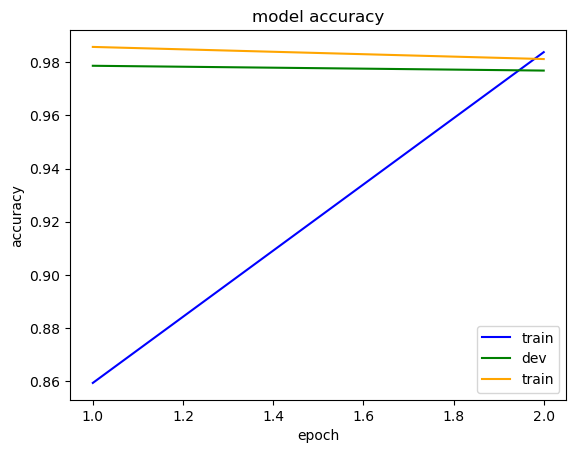

In [19]:
import matplotlib.pyplot as plt

# create two sets of bars with different colors
plt.plot(accuracy.keys(), accuracy.values(), color='blue', label='Dict 1')
plt.plot(accuracy_dev.keys(), accuracy_dev.values(), color='green', label='Dict 2')
plt.plot(accuracy_test.keys(), accuracy_test.values(), color='orange', label='Dict 3')
# plt.ylim(0.8, 1.0)

# add legend, labels and title
plt.legend(['train','dev', 'train'], loc="lower right")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()


In [20]:
test_sentence = "i would like the cheapest flight from pittsburgh to atlanta leaving april twenty fifth and returning may sixth".lower().split()

inputs = texts_to_sequences(test_sentence, word2idx)
inputs = inputs
tag_scores = model(inputs)
print(tag_scores)

_, predicted_tags = torch.max(tag_scores, 1)
print('\n')
print('Predicted tags: \n',predicted_tags)

tensor([[-4.9472e-03, -7.2352e+00, -8.2685e+00, -9.2599e+00, -1.0601e+01,
         -7.7223e+00, -8.6438e+00, -1.0798e+01, -1.0655e+01, -1.4042e+01,
         -7.5271e+00, -9.6936e+00, -5.9653e+00, -1.1782e+01],
        [-9.0960e+00, -1.3862e-03, -1.0187e+01, -1.1260e+01, -1.2840e+01,
         -1.3824e+01, -8.1907e+00, -1.3382e+01, -7.7792e+00, -1.0228e+01,
         -8.1581e+00, -8.9770e+00, -9.5464e+00, -1.3368e+01],
        [-7.8967e+00, -4.7146e+00, -6.0093e+00, -8.1589e+00, -4.6243e+00,
         -8.9352e+00, -5.2294e-01, -8.8775e+00, -1.0644e+00, -5.6854e+00,
         -3.4193e+00, -5.7576e+00, -7.0957e+00, -1.0451e+01],
        [-9.4594e+00, -9.4756e+00, -3.0954e-04, -1.2677e+01, -1.2902e+01,
         -1.2332e+01, -1.1966e+01, -1.2196e+01, -9.3819e+00, -1.3148e+01,
         -1.0761e+01, -1.0597e+01, -1.3926e+01, -1.5575e+01],
        [-1.6890e+01, -1.1638e+01, -9.2641e+00, -9.8847e+00, -1.2136e+01,
         -1.1466e+01, -1.2377e+01, -1.1976e+01, -3.0620e-04, -1.0397e+01,
         -9.

In [21]:
# print(idx2tag)
ct = 0
for i in predicted_tags:
#     if(test_sentence[ct] not in word2idx.keys()):
#         print("(",end="\"")
#         print(test_sentence[ct], end="\",\"")
#         print("UNK",end="\"),")
#         ct += 1
#         continue
    print(test_sentence[ct], end="\t")
    print(idx2tag[i.item()])
    ct += 1

i	PRON
would	AUX
like	VERB
the	DET
cheapest	ADJ
flight	NOUN
from	ADP
pittsburgh	PROPN
to	ADP
atlanta	PROPN
leaving	VERB
april	NOUN
twenty	NUM
fifth	ADJ
and	CCONJ
returning	VERB
may	NOUN
sixth	ADJ
